In [1]:
import numpy as np
import pandas as pd 
import scipy as sp
import scipy.io
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import fnmatch
import re
import argparse

import sys, getopt

In [2]:
df_cal_ch2_1 = pd.read_csv("./calib_ch2_csvfiles/calib_ch2_500files.csv")
df_cal_ch2_1.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,50003,50004,Saturated,Pedestal,n pe,pe height,pe width,pe area,spe 1sig,spe 2sig
0,0,e,/pro,2020-03-04 14:35:38.993,NaN,NaN,NaN,NaN,NaN,NaN,...,384.813025,4864,False,4650.194975,0.0,0.000000,0.000000,0.000000e+00,False,False
1,1,e,/pro,2020-03-04 14:35:39.474252013,NaN,NaN,NaN,NaN,NaN,NaN,...,61.321648,5376,False,4759.670352,1.0,5917.577648,1091.412698,4.889310e+06,True,True
2,2,e,/pro,2020-03-04 14:35:39.524757315,NaN,NaN,NaN,NaN,NaN,NaN,...,292.261950,5120,False,4702.810050,0.0,0.000000,0.000000,0.000000e+00,False,False
3,3,e,/pro,2020-03-04 14:35:39.544113686,NaN,NaN,NaN,NaN,NaN,NaN,...,-361.950553,4096,False,5062.110553,1.0,3696.161447,994.468750,2.859028e+06,True,True
4,4,e,/pro,2020-03-04 14:35:39.559605878,NaN,NaN,NaN,NaN,NaN,NaN,...,260.975920,4608,False,4636.816080,0.0,0.000000,0.000000,0.000000e+00,False,False


In [3]:
df_cal_ch2_2 = pd.read_csv("./calib_ch2_csvfiles/calib_ch2_501-1000files.csv")
df_cal_ch2_2.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,50003,50004,Saturated,Pedestal,n pe,pe height,pe width,pe area,spe 1sig,spe 2sig
0,0,e,/pro,2020-03-04 14:35:59.694,NaN,NaN,NaN,NaN,NaN,NaN,...,521.462995,4864,False,4737.801005,0.0,0.000,0.000000,0.000,False,False
1,1,e,/pro,2020-03-04 14:35:59.716,NaN,NaN,NaN,NaN,NaN,NaN,...,335.043538,4608,False,4645.692462,0.0,0.000,0.000000,0.000,False,False
2,2,e,/pro,2020-03-04 14:35:59.761,NaN,NaN,NaN,NaN,NaN,NaN,...,483.250814,5376,False,4777.037186,0.0,0.000,0.000000,0.000,False,False
3,3,e,/pro,2020-03-04 14:35:59.796,NaN,NaN,NaN,NaN,NaN,NaN,...,522.240000,4352,False,4505.600000,1.0,4962.304,842.065217,3230931.968,True,True
4,4,e,/pro,2020-03-04 14:35:59.841,NaN,NaN,NaN,NaN,NaN,NaN,...,236.703518,4352,False,4704.096482,0.0,0.000,0.000000,0.000,False,False


In [4]:
print('full 1st dataset:', df_cal_ch2_1.shape)
print('n pe > 0:', df_cal_ch2_1.loc[df_cal_ch2_1['n pe']>0].shape)
print('spe 1sig ==True:', df_cal_ch2_1.loc[df_cal_ch2_1['spe 1sig']==True].shape)


full 1st dataset: (500, 50014)
n pe > 0: (304, 50014)
spe 1sig ==True: (301, 50014)


In [6]:
print('full 2nd dataset:', df_cal_ch2_2.shape)
print('n pe > 0:', df_cal_ch2_2.loc[df_cal_ch2_2['n pe']>0].shape)
print('spe 1sig ==True:', df_cal_ch2_2.loc[df_cal_ch2_2['spe 1sig']==True].shape)


full 2nd dataset: (499, 50014)
n pe > 0: (311, 50014)
spe 1sig ==True: (307, 50014)


In [7]:
X_pe_calib1=df_cal_ch2_1.loc[(df_cal_ch2_1['pe height']>0)&
      (df_cal_ch2_1['pe width']>0),['pe height', 'pe width']].values

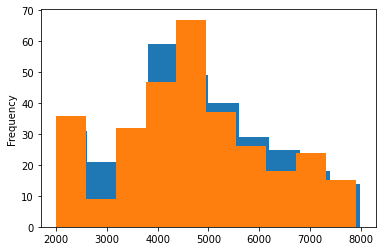

In [8]:
df_cal_ch2_1.loc[(df_cal_ch2_1['pe height']>0)]['pe height'].plot(kind='hist', label='sample 1')
df_cal_ch2_2.loc[(df_cal_ch2_2['pe height']>0)]['pe height'].plot(kind='hist', label='sample 2')

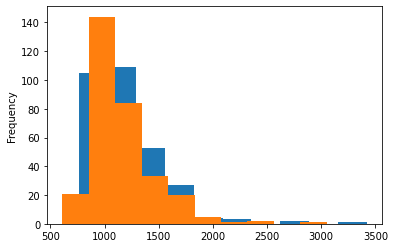

In [9]:
df_cal_ch2_1.loc[(df_cal_ch2_1['pe height']>0)]['pe width'].plot(kind='hist', label='sample 1')
df_cal_ch2_2.loc[(df_cal_ch2_2['pe height']>0)]['pe width'].plot(kind='hist', label='sample 2')

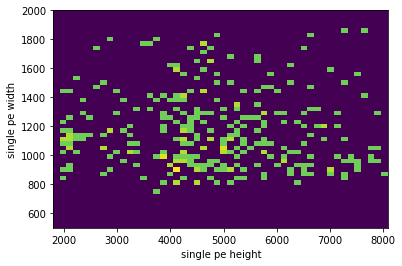

In [11]:
plt.hist2d(df_cal_ch2_1['pe height'], df_cal_ch2_1['pe width'], 
           [50,50], range=[[1800,8100],[500,2000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('single pe height')
plt.ylabel('single pe width')

plt.show()

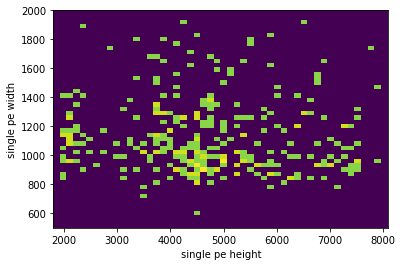

In [10]:
plt.hist2d(df_cal_ch2_2['pe height'], df_cal_ch2_2['pe width'], 
           [50,50], range=[[1800,8100],[500,2000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('single pe height')
plt.ylabel('single pe width')

plt.show()

In [14]:
df_ch2calib_merged = df_cal_ch2_1.copy()
df_ch2calib_merged = df_ch2calib_merged.append(df_cal_ch2_2, ignore_index = True) 
df_ch2calib_merged.shape

(999, 50014)

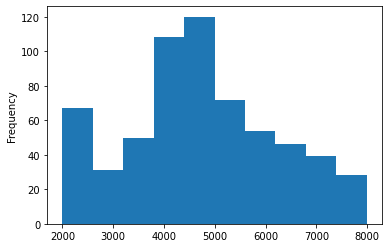

In [16]:
df_ch2calib_merged.loc[(df_ch2calib_merged['pe height']>0)]['pe height'].plot(kind='hist')


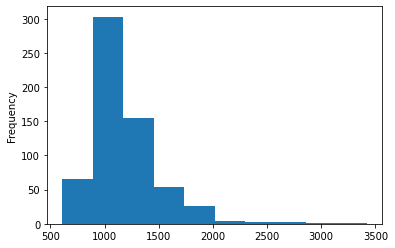

In [18]:
df_ch2calib_merged.loc[(df_ch2calib_merged['pe height']>0)]['pe width'].plot(kind='hist')


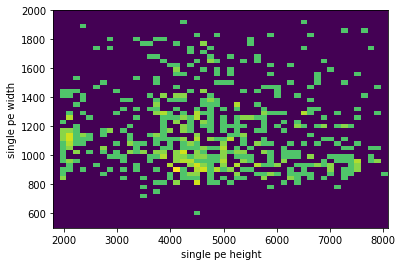

In [19]:
plt.hist2d(df_ch2calib_merged['pe height'], df_ch2calib_merged['pe width'], 
           [50,50], range=[[1800,8100],[500,2000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('single pe height')
plt.ylabel('single pe width')

plt.show()

In [20]:
df_ch2_sel = df_ch2calib_merged.loc[df_ch2calib_merged['spe 1sig']==True]
df_ch2_sel.shape

(608, 50014)

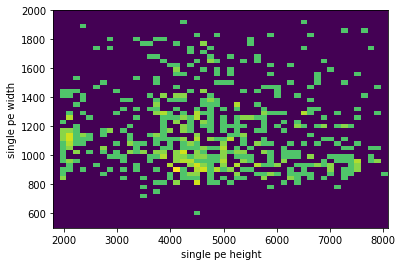

In [21]:
plt.hist2d(df_ch2_sel['pe height'], df_ch2_sel['pe width'], 
           [50,50], range=[[1800,8100],[500,2000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('single pe height')
plt.ylabel('single pe width')

plt.show()

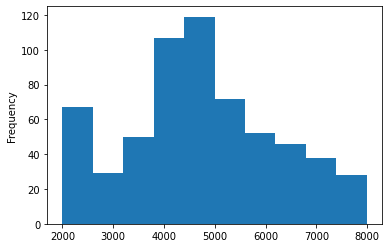

In [22]:
df_ch2_sel.loc[(df_ch2_sel['pe height']>0)]['pe height'].plot(kind='hist')


In [23]:
df_cal_ch2_clean = pd.read_csv("./calib_ch2_csvfiles/calib15june-ch2_0-300files_prominence2000.csv")
df_cal_ch2_clean.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,100003,100004,Saturated,Pedestal,n pe,pe height,pe width,pe area,spe 1sig,spe 2sig
0,0,e,/pro,2020-06-15 11:35:05.950432224,NaN,NaN,NaN,NaN,NaN,NaN,...,4352,4352,False,4304.787940,0.0,0.000,0.000000,0.000000e+00,False,False
1,1,e,/pro,2020-06-15 11:35:05.983038603,NaN,NaN,NaN,NaN,NaN,NaN,...,3328,3584,False,4422.239196,1.0,3735.552,1071.583333,2.827751e+06,True,True
2,2,e,/pro,2020-06-15 11:35:05.470,NaN,NaN,NaN,NaN,NaN,NaN,...,3840,3840,False,4216.667337,1.0,4625.408,1082.586538,3.705332e+06,True,True
3,3,e,/pro,2020-06-15 11:35:05.503,NaN,NaN,NaN,NaN,NaN,NaN,...,2816,3328,False,4184.120603,1.0,3371.008,1136.708333,2.698525e+06,True,True
4,4,e,/pro,2020-06-15 11:35:05.535,NaN,NaN,NaN,NaN,NaN,NaN,...,2816,3328,False,4076.446231,1.0,3910.656,1097.196429,3.054529e+06,True,True


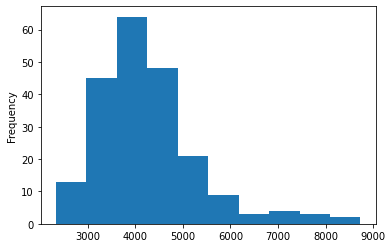

In [26]:
df_cal_ch2_clean.loc[(df_cal_ch2_clean['spe 1sig']==True)]['pe height'].plot(kind='hist')


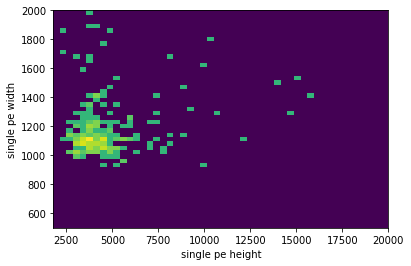

In [36]:
plt.hist2d(df_cal_ch2_clean['pe height'], df_cal_ch2_clean['pe width'], 
           [50,50], range=[[1800,20000],[500,2000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('single pe height')
plt.ylabel('single pe width')

plt.show()

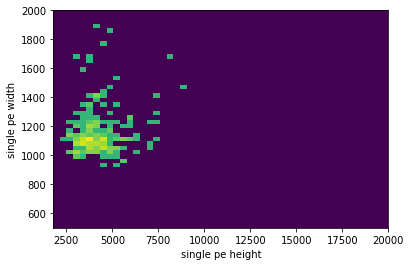

In [37]:
df_cal_ch2_clean_sel = df_cal_ch2_clean.loc[(df_cal_ch2_clean['spe 1sig']==True)]

plt.hist2d(df_cal_ch2_clean_sel['pe height'], df_cal_ch2_clean_sel['pe width'], 
           [50,50], range=[[1800,20000],[500,2000]],
           cmap='viridis',
           norm=mcolors.PowerNorm(0.18))
plt.xlabel('single pe height')
plt.ylabel('single pe width')

plt.show()


In [30]:
def do_average_singlepe(df):

    area = df.loc[(df['spe 1sig']==True) ]['pe area'].mean()
    std  = df.loc[(df['spe 1sig']==True) ]['pe area'].std()

    return area, std

In [32]:
area_ch2_1, std_ch2_1 = do_average_singlepe(df_cal_ch2_1)
area_ch2_2, std_ch2_2 = do_average_singlepe(df_cal_ch2_2)
area_ch2_merged, std_ch2_merged = do_average_singlepe(df_ch2calib_merged)
area_clean, std_clean = do_average_singlepe(df_cal_ch2_clean)

print('sample 1: area=', area_ch2_1, ' std= ', std_ch2_1 )
print('sample 2: area=', area_ch2_2, ' std= ', std_ch2_2 )
print('sample merged: area=', area_ch2_merged, ' std= ', std_ch2_merged )
print('sample clean: area=', area_clean, ' std= ', std_clean )



sample 1: area= 4264113.323535685  std=  1729878.9020412832
sample 2: area= 4057871.2755564135  std=  1655174.8242638952
sample merged: area= 4159974.657861942  std=  1694320.3143433137
sample clean: area= 3664854.5054995734  std=  1244062.9381198152
